# Thall et al 2005

Following the modeling in 

Thall, Peter F, Leiko H Wooten, and Nizar M Tannir. “Monitoring Event Times in Early Phase Clinical Trials: Some Practical Issues.” Clinical Trials 2, no. 6 (December 2005): 467–78. https://doi.org/10.1191/1740774505cn121oa.

I also found the notes here to be useful for learning about survival analysis. Before writing this document, I had zero prior survival analysis experience: https://web.stanford.edu/~lutian/coursepdf/slideweek1.pdf 

## Section 1: "A simple trial design for the Xeloda + Gemzar trial".

### Data model

Time to treatment failure: $T = \min(T_P, T_D)$ where $T_P$ is time to progression and $T_D$ is time to death.

assume $T$ is exponentially distributed:
\begin{align}
p(t | \mu) = \exp(-t / \mu) / \mu
\end{align}

or alternatively, in terms of the event rate parameter $\lambda$, because $\mu = 1 / \lambda$:
\begin{align}
p(t | \lambda) =  \lambda \exp(-t\lambda)
\end{align}

It's also possible to parameterize in terms of the median: $\tilde{\mu} = \mathrm{median}(T) = \log(2) \mu$. 

### Prior

We assume $\mu$ follows an inverse gamma prior:

\begin{align}
p(\mu|a, b) = \exp(-b / \mu) b^a \mu^{-(a + 1)} / \Gamma(a)
\end{align}

Note that this equivalent to assuming a gamma prior for $\lambda$. Also, Thall sometimes discusses parameterization of the prior in terms of the median time to treatment failure which just involves multiplying by $\log(2)$ as above.

Importantly, this is a conjugate prior.

### Other notation.

Variables subscripted with $S$ are referring to the standard therapy while those subscripted with $E$ refer to the experimental therapy.

In [1]:
import sys
sys.path.append('../kevlar/research/berry/')
import berrylib.util as util
util.setup_nb()

In [2]:
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt

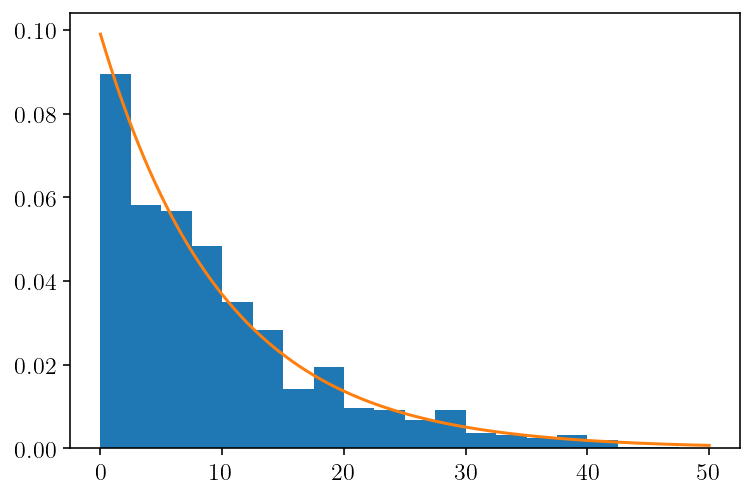

In [3]:
med_E_true = 7
mean_E_true = 7 / np.log(2)
mean_E_true

N = 1000
samples = scipy.stats.expon.rvs(scale = mean_E_true, size=N)
t = np.linspace(0, 50, 1000)
pdf = scipy.stats.expon.pdf(t, scale=mean_E_true)
bins = np.linspace(0, 50, 21)
plt.hist(samples, bins=bins, density=True)
plt.plot(t, pdf)
plt.show()

We will take 6 new patients into the trial each month for 14 months, observing the patients for 

In [4]:
n_months = 14
n_samples = 14 * 6
seed = 10
np.random.seed(seed)
ttf = scipy.stats.expon.rvs(scale=mean_E_true, size=n_samples)
start_date = np.repeat(np.arange(14), 6)
failure_date = start_date + ttf
Y = failure_date > n_months
T = np.minimum(failure_date, n_months) - start_date

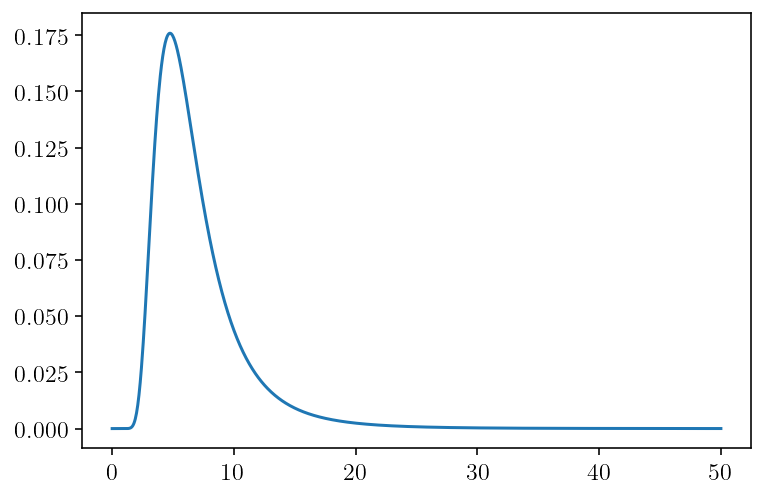

prior mean 6.936752529898804


In [5]:
a = 5.348
b = 30.161

t = np.linspace(0, 50, 1000)
pdf = scipy.stats.invgamma.pdf(t, a, scale=b)
plt.plot(t, pdf)
plt.show()
print('prior mean', scipy.stats.invgamma.mean(a, scale=b))

### Version 1: Conjugate prior

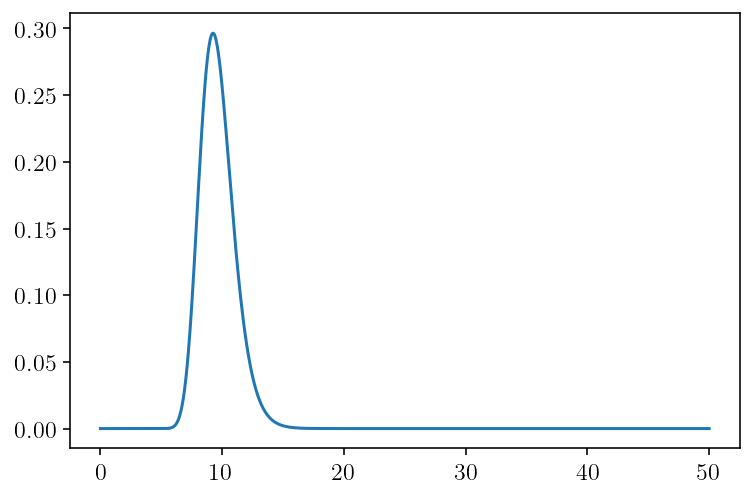

posterior mean 9.637058031194403


In [6]:
a = 5.348
b = 30.161

a_post = a + Y.sum()
b_post = b + T.sum()
t = np.linspace(0, 50, 1000)
pdf = scipy.stats.invgamma.pdf(t, a_post, scale=b_post)
plt.plot(t, pdf)
plt.show()
exact_mean = scipy.stats.invgamma.mean(a_post, scale=b_post)
print('posterior mean', exact_mean)

### Version 2: MCMC

In [7]:
import numpyro
import numpyro.distributions as dist
import numpyro.infer

import jax
import jax.numpy as jnp

from jax.config import config
# This line is critical for enabling 64-bit floats.
config.update("jax_enable_x64", True)

/Users/tbent/.mambaforge/envs/kevlar/lib/python3.9/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "
/Users/tbent/.mambaforge/envs/kevlar/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
class CensoredExponential(dist.Distribution):
    def __init__(self, hazard, n_samples, start_dates, validate_args=None):
        self.hazard = hazard
        self.n_samples = n_samples
        self.start_dates = start_dates
        self.expon = dist.Exponential(self.hazard)
        super(CensoredExponential, self).__init__(
            batch_shape=jnp.shape(hazard), validate_args=validate_args
        )

    def sample(self, key):
        ttf = self.expon.sample(key, sample_shape=(self.n_samples,))
        failure_date = ttf + self.start_dates
        failure_date > n_months

    def log_prob(self, YT):
        return jnp.sum(
            jnp.where(
                YT[:, 0],
                self.expon.log_prob(YT[:, 1]),
                -YT[:, 1] * self.hazard,
            )
        )

In [9]:
def sample(YT):
    mean_ttf = numpyro.sample("mu", dist.InverseGamma(a, b))
    hazard = numpyro.deterministic("lambda", 1.0 / mean_ttf)
    numpyro.sample("YT", CensoredExponential(hazard, n_samples, start_date), obs=YT)

seed = 10
n_samples = 100000
nuts_kernel = numpyro.infer.NUTS(sample)
mcmc = numpyro.infer.MCMC(
    nuts_kernel,
    progress_bar=False,
    num_warmup=100,
    num_samples=n_samples,
)
rng_key = jax.random.PRNGKey(seed)
YT = np.stack((Y, T), axis=-1)
mcmc.run(rng_key, YT)

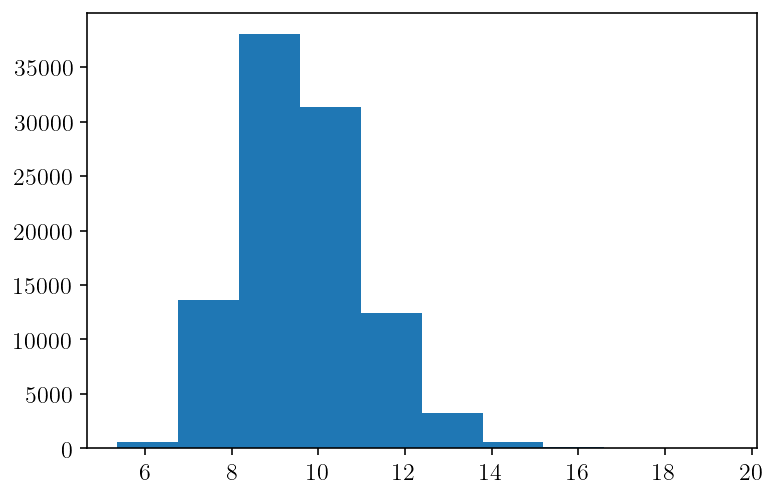

mcmc mean 9.634297554877127
mcmc pct err 0.02864438823902763


In [10]:
mu_samples = mcmc.get_samples()['mu'].to_py()
plt.hist(mu_samples)
plt.show()
mcmc_mean = mu_samples.mean()
print('mcmc mean', mcmc_mean)
print('mcmc pct err', 100 * np.abs(mcmc_mean - exact_mean) / exact_mean)

### Version 3: Integration

In [11]:
mean_ttf_qr = util.gauss_rule(50, a = 0, b = 30)
log_prior = scipy.stats.invgamma.logpdf(mean_ttf_qr.pts, a, scale=b)
log_prior

array([-1733.39933455,  -307.09487208,  -113.16605082,   -53.89049602,
         -29.11253147,   -16.91580857,   -10.31391387,    -6.53752796,
          -4.31911115,    -3.01594175,    -2.27617664,    -1.89543823,
          -1.74928346,    -1.75899839,    -1.87321506,    -2.05753455,
          -2.2884221 ,    -2.54948655,    -2.82914302,    -3.11910499,
          -3.41338884,    -3.70764295,    -3.99868733,    -4.2841926 ,
          -4.56245283,    -4.83222269,    -5.09259941,    -5.34293625,
          -5.58277851,    -5.81181582,    -6.02984624,    -6.23674913,
          -6.43246446,    -6.61697706,    -6.7903044 ,    -6.95248722,
          -7.10358231,    -7.24365679,    -7.37278379,    -7.49103897,
          -7.59849787,    -7.69523384,    -7.78131636,    -7.85680983,
          -7.92177255,    -7.97625598,    -8.02030418,    -8.05395339,
          -8.07723217,    -8.09016512])

In [12]:
# check that we're integrating over a sufficiently wide domain.
scipy.stats.invgamma.cdf(mean_ttf_qr.pts[-1], a, scale=b)

0.99796677581133

In [13]:
n_failures = YT[:,0].sum()
total_obs_time = YT[:,1].sum()
def log_likelihood(mean_ttf): 
    return -n_failures * np.log(mean_ttf) + -total_obs_time / mean_ttf

In [14]:
logpdf = (log_prior + log_likelihood(mean_ttf_qr.pts))
pdf = np.exp(logpdf)
pdf /= np.sum(pdf * mean_ttf_qr.wts)

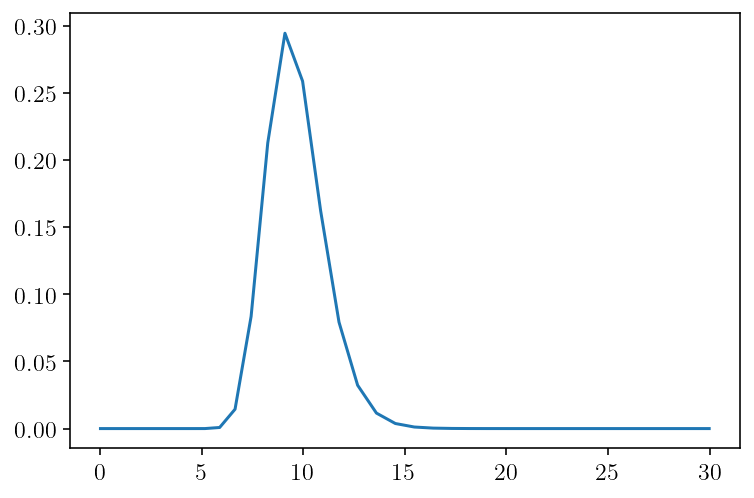

In [15]:

plt.plot(mean_ttf_qr.pts, pdf)
plt.show()

In [16]:
integral_mean = np.sum(mean_ttf_qr.pts * pdf * mean_ttf_qr.wts)
print('integral mean', integral_mean)
print('integral pct err', 100 * np.abs(integral_mean - exact_mean) / exact_mean)

integral mean 9.637058033544406
integral pct err 2.4385064937539606e-08


### Version 4: INLA-ish

This is degenerate in the sense that there is no hyperparameter. So, we just approximate the prior with a normal distribution.

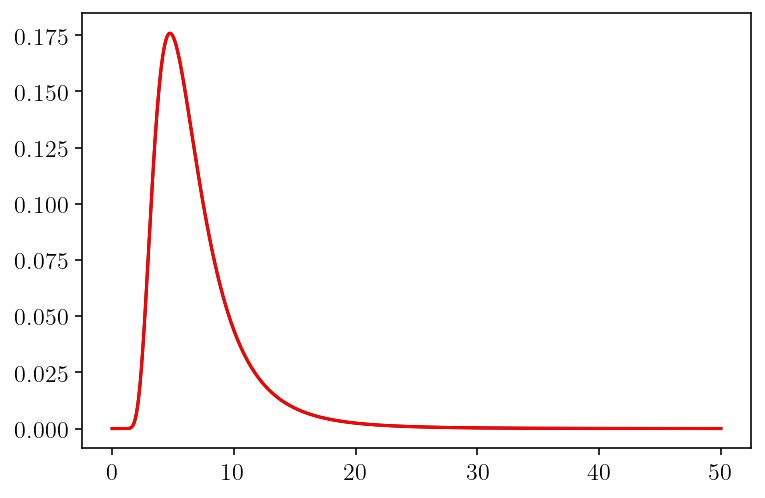

In [17]:
t = np.linspace(0.001, 50, 1000)
invt = 1.0 / t
a_g = a / b
b_g = a / (b ** 2)
pdf2 = scipy.stats.invgamma.pdf(t, a, scale=b)
pdf3 = jnp.exp(-b / t) * (b ** a) * (t ** -(a + 1)) / jnp.exp(jax.scipy.special.gammaln(a))

plt.plot(t, pdf2, 'k-')
plt.plot(t, pdf3, 'r-')
plt.show()

In [18]:
# n_failures = YT[:,0].sum()
# total_obs_time = YT[:,1].sum()
# def log_likelihood(mean_ttf): 
#     return -n_failures * np.log(mean_ttf) + -total_obs_time / mean_ttf
def log_joint(mean_ttf):
    log_prior = -b / mean_ttf + a * jnp.log(b) - (a+1) * jnp.log(mean_ttf) - jax.scipy.special.gammaln(a)
    log_likelihood = -n_failures * jnp.log(mean_ttf) + -total_obs_time / mean_ttf
    return log_prior + log_likelihood
log_joint(jnp.linspace(5, 15, 11))

DeviceArray([-156.1786532 , -149.96600992, -146.70886092, -145.15023552,
             -144.62515632, -144.7545379 , -145.30976443, -146.14681835,
             -147.17179523, -148.32175772, -149.55358259], dtype=float64)

In [19]:
grad_fnc = jax.grad(log_joint)
hess_fnc = jax.hessian(log_joint)

In [20]:
tff_max = 1.0
tol = 1e-4
for i in range(100):
    grad = grad_fnc(tff_max)
    hess = hess_fnc(tff_max)
    step = -grad / hess
    tff_max += step
    if np.abs(step) < tol:
        break
print(f'soln={tff_max} took iters={i}')

soln=9.246482606407369 took iters=10


In [21]:
log_joint(tff_max)

DeviceArray(-144.6069808, dtype=float64)

In [22]:
tff_max, hess

(DeviceArray(9.24648261, dtype=float64, weak_type=True),
 DeviceArray(-0.57718697, dtype=float64, weak_type=True))

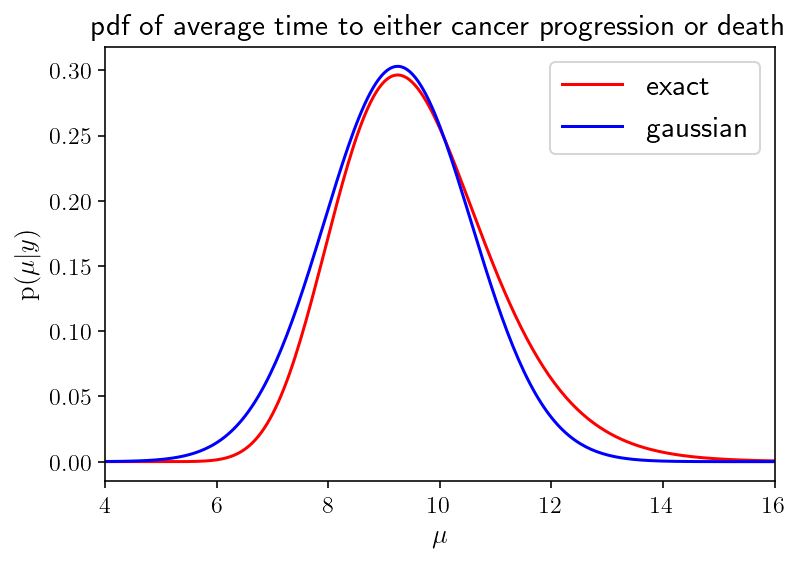

In [23]:
std_dev = np.sqrt(-1.0 / hess)
t = np.linspace(0, 50, 1000)
pdf = scipy.stats.invgamma.pdf(t, a_post, scale=b_post)
plt.plot(t, pdf, 'r-', label='exact')
plt.plot(t, scipy.stats.norm.pdf(t, tff_max, scale=std_dev), 'b-', label='gaussian')
plt.xlim([4, 16])
plt.xlabel('$\mu$')
plt.ylabel('$\mathrm{p}(\mu | y)$')
plt.legend()
plt.title('pdf of average time to either cancer progression or death')
plt.show()

The result above might be improved with a skew-normal "simplified laplace approximation" from section 3.2.3 in Rue et al 2009.

In [24]:
skew = jax.grad(hess_fnc)(tff_max)
skew

DeviceArray(0.24968927, dtype=float64)

## Section 2: Interval censoring

In [1]:
import sys
sys.path.append('../kevlar/research/berry/')
import berrylib.util as util
util.setup_nb()

In [2]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import numpyro
import numpyro.distributions as dist
import numpyro.infer

import jax
import jax.numpy as jnp

from jax.config import config
# This line is critical for enabling 64-bit floats.
config.update("jax_enable_x64", True)

/Users/tbent/.mambaforge/envs/kevlar/lib/python3.9/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "
/Users/tbent/.mambaforge/envs/kevlar/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
n_patients = 14 * 6
max_n_months = 14
evaluation_period = 2


def simulate_dataset(seed, mean_ED_true, mean_EP_true):
    np.random.seed(seed)
    ttfP = scipy.stats.expon.rvs(scale=mean_EP_true, size=n_patients)
    ttfD = scipy.stats.expon.rvs(scale=mean_ED_true, size=n_patients)
    start_date = np.linspace(0, 14, n_patients)
    P_date = start_date + ttfP
    D_date = start_date + ttfD
    return np.stack((start_date, D_date, P_date), axis=-1)
    
def sufficient_stats(data, n_months):
    start_date, D_date, P_date = data.T

    evaluation_dates = (
        start_date[:, None]
        + (evaluation_period * np.arange(max_n_months // 2 + 1))[None, :]
    )
    Y_da = D_date <= n_months

    # Only include evaluations that are within the time frame of the trial.
    include_eval = evaluation_dates <= n_months
    # For each patient and each time period, did we observe a progression?
    progress = (
        (evaluation_dates[:, :-1] < P_date[:, None])
        & (P_date[:, None] < evaluation_dates[:, 1:])
        & (evaluation_dates[:, 1:] < D_date[:, None])
        & include_eval[:, 1:]
    )
    Y_p = np.any(progress, axis=1)

    tau_k0 = np.empty(data.shape[0])
    tau_k0[Y_p] = evaluation_dates[:, 1:][progress]

    # This is some ugly code that figures out when the last observation of a patient was.
    last_observation_idx = (
        np.argmin(
            (evaluation_dates <= n_months) & (evaluation_dates < D_date[:, None]),
            axis=1,
        )
        - 1
    )
    tau_k0[~Y_p] = (
        evaluation_dates[np.arange(evaluation_dates.shape[0]), last_observation_idx]
    )[~Y_p]
    tau_k0 -= start_date

    T0 = np.minimum(D_date, n_months) - start_date

    data = np.stack((Y_p, tau_k0, Y_da, T0), axis=-1)
    return data

In [4]:
mean_EP_true = 6 / np.log(2)
mean_ED_true = 12 / np.log(2)
raw_data = simulate_dataset(10, mean_ED_true, mean_EP_true)
data = sufficient_stats(raw_data, max_n_months)

In [5]:
# Check that we never have progression after death
prog_after_death = (data[:,0].astype(bool) & data[:,2].astype(bool)) & (data[:,1] >= data[:,3])
assert(np.all(~prog_after_death))

In [6]:
# Check that last progression observation date is never after death
assert(np.all(data[:,1] <= data[:,3]))

In [7]:
data[:,0].astype(bool) & (data[:,1] < 2)

array([False, False, False, False, False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False])

In [8]:
def survivor_fnc(x, ttf): 
    return 1.0 - scipy.stats.expon.cdf(x, scale=ttf)

def log_likelihood_explicit(data, ttf_da, ttf_p):
    Y_p, tau_k0, Y_da, T0 = data.T
    death_term = np.where(
        Y_da, scipy.stats.expon.pdf(T0, scale=ttf_da), survivor_fnc(T0, ttf_da)
    )
    pi_k0 = (
        survivor_fnc(tau_k0 - evaluation_period, ttf_p) 
        - survivor_fnc(tau_k0, ttf_p)
    )
    progression_term = np.where(Y_p, pi_k0, survivor_fnc(tau_k0, ttf_p))
    return np.sum(np.log(death_term) + np.log(progression_term))

def log_likelihood(data, ttf_da, ttf_p):
    Y_p, tau_k0, Y_da, T0 = data.T
    N_da = Y_da.sum()
    T_p = (tau_k0 * (1 - Y_p)).sum()
    T_da = T0.sum()
    death_term = -N_da * np.log(ttf_da) + -T_da / ttf_da
    progression_term = -T_p / ttf_p + np.sum(
        np.log(np.exp(-(tau_k0 - evaluation_period) / ttf_p) - np.exp(-tau_k0 / ttf_p))
        * Y_p
    )
    return death_term + progression_term

log_likelihood(data, mean_ED_true, mean_EP_true), log_likelihood_explicit(data, mean_ED_true, mean_EP_true)

(-189.29307610542156, -189.29307610542156)

In [9]:
class IntervalCensored(dist.Distribution):
    def __init__(self, mu_da, mu_p, validate_args=None):
        self.mu_da = mu_da
        self.mu_p = mu_p
        super(IntervalCensored, self).__init__(
            batch_shape=jnp.shape(mu_p), validate_args=validate_args
        )

    def sample(self, key):
        raise NotImplementedError()

    def log_prob(self, data):
        Y_p, tau_k0, Y_da, T0 = data.T
        N_da = Y_da.sum()
        T_p = (tau_k0 * (1 - Y_p)).sum()
        T_da = T0.sum()
        death_term = -N_da * jnp.log(self.mu_da) + -T_da / self.mu_da
        progression_term = -T_p / self.mu_p + jnp.sum(
            jnp.log(jnp.exp(-(tau_k0 - evaluation_period) / self.mu_p) - jnp.exp(-tau_k0 / self.mu_p))
            * Y_p
        )
        return death_term + progression_term

In [10]:
IntervalCensored(mean_ED_true, mean_EP_true).log_prob(data)

DeviceArray(-189.29307611, dtype=float64)

In [12]:
a_Sp, b_Sp = 20.391, 195.826
a_Sda, b_Sda = 95.401, 1303.670
a_Ep, b_Ep = 2.039, 19.583
a_Eda, b_Eda = 9.540, 130.367
def sample(data):
    numpyro.sample("mu_Sp", dist.InverseGamma(a_Sp, b_Sp))
    numpyro.sample("mu_Sda", dist.InverseGamma(a_Sda, b_Sda))
    mean_ttf_Ep = numpyro.sample("mu_Ep", dist.InverseGamma(a_Ep, b_Ep))
    mean_ttf_Eda = numpyro.sample("mu_Eda", dist.InverseGamma(a_Eda, b_Eda))
    numpyro.sample("data", IntervalCensored(mean_ttf_Eda, mean_ttf_Ep), obs=data)

seed = 10
n_samples = 10000
nuts_kernel = numpyro.infer.NUTS(sample)
mcmc = numpyro.infer.MCMC(
    nuts_kernel,
    progress_bar=False,
    num_warmup=100,
    num_samples=n_samples,
)
rng_key = jax.random.PRNGKey(seed)
mcmc.run(rng_key, data)

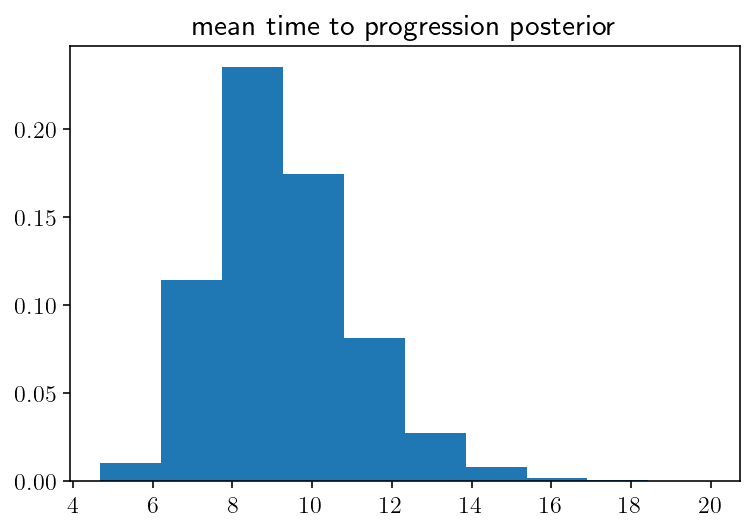

mcmc mean ttf progression 9.270903432879917


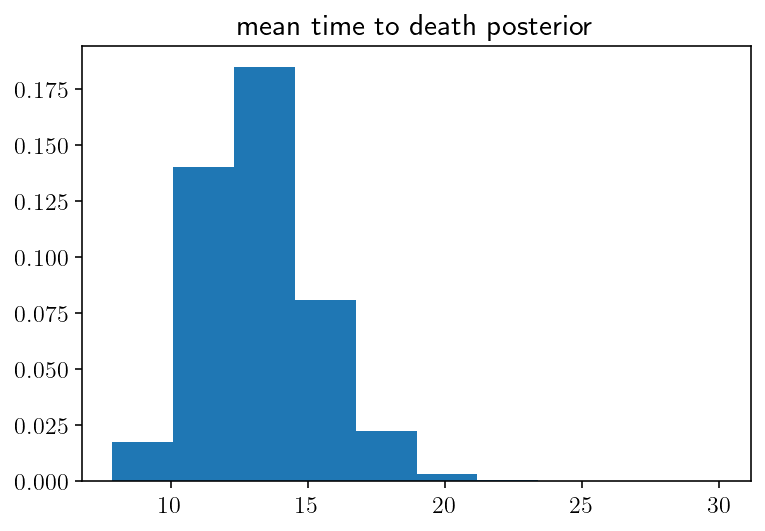

mcmc mean ttf death 13.243848126735532


In [13]:
mu_p_samples = mcmc.get_samples()['mu_Ep'].to_py()
plt.title('mean time to progression posterior')
plt.hist(mu_p_samples, density=True)
plt.show()
mcmc_p_mean = mu_p_samples.mean()
print('mcmc mean ttf progression', mcmc_p_mean)

mu_da_samples = mcmc.get_samples()['mu_Eda'].to_py()
plt.title('mean time to death posterior')
plt.hist(mu_da_samples, density=True)
plt.show()
mcmc_da_mean = mu_da_samples.mean()
print('mcmc mean ttf death', mcmc_da_mean)

In [18]:
med_EP_true = 6
med_ED_true = 12
mean_EP_true = med_EP_true / np.log(2)
mean_ED_true = med_ED_true / np.log(2)
print('full ttf', 1.0 / ((1.0 / mean_EP_true) + (1.0 / mean_ED_true)) * np.log(2))
mean_ED_true, mean_EP_true

full ttf 4.0


(17.312340490667562, 8.656170245333781)

In [19]:
n_samples = 3000
kernel = numpyro.infer.NUTS(sample)
mcmc = numpyro.infer.MCMC(
    kernel,
    progress_bar=False,
    num_warmup=100,
    num_samples=n_samples,
    jit_model_args=True
)

In [20]:
%%time
N_sim = 100
means = np.empty((N_sim, 2))
rng_key = jax.random.PRNGKey(10)
for i in range(N_sim):
    seed = 10 + i
    data_i = sufficient_stats(simulate_dataset(seed, mean_ED_true, mean_EP_true), max_n_months)
    mcmc.run(rng_key, data_i)

    samples = mcmc.get_samples()
    mcmc_da_mean = samples['mu_Eda'].mean()
    mcmc_p_mean = samples['mu_Ep'].mean()
    means[i, :] = (mcmc_da_mean, mcmc_p_mean)

CPU times: user 6.97 s, sys: 55.8 ms, total: 7.03 s
Wall time: 7.02 s


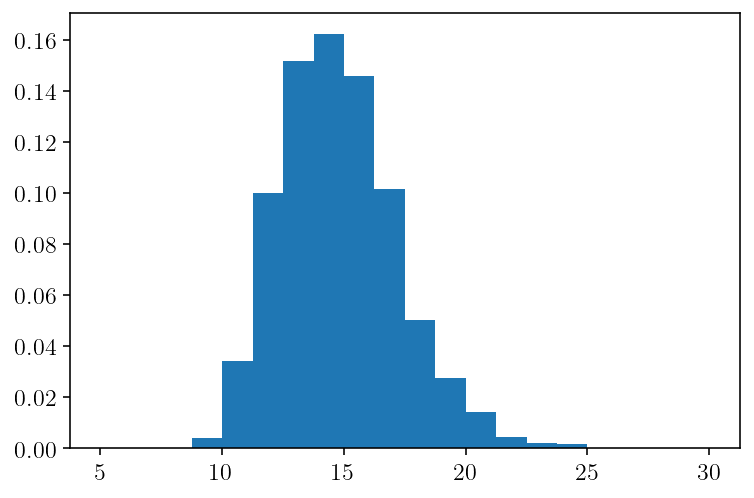

In [21]:
plt.hist(samples['mu_Eda'].to_py(), bins=np.linspace(5, 30, 21), density=True)
plt.show()

In [22]:
print('est', means[:,0].mean(), means[:,1].mean())
print('true', mean_ED_true, mean_EP_true)

est 16.874994305922797 8.751654221422818
true 17.312340490667562 8.656170245333781


In [25]:
mean_EP_true = 6.0 / np.log(2)
mean_ED_true = 12.0 / np.log(2)
# mean_EP_true = 10.0 / np.log(2)
# mean_ED_true = 23.33 / np.log(2)
p_L = 0.019
N_sim = 100
n_patients_early = np.empty(N_sim, dtype=np.int32)
for i in range(N_sim):
    seed = 10 + i
    rawdata_i = simulate_dataset(seed, mean_ED_true, mean_EP_true)
    for t in range(1, n_patients + 1):
        raw_ti = rawdata_i[:t]
        suff_ti = sufficient_stats(raw_ti, raw_ti[-1, 0])
        mcmc.run(rng_key, suff_ti)
        samples = mcmc.get_samples()
        mu_S = 1.0 / (1.0 / samples['mu_Sda'] + 1.0 / samples['mu_Sp'])
        mu_E = 1.0 / (1.0 / samples['mu_Eda'] + 1.0 / samples['mu_Ep'])
        pr_success = jnp.sum(mu_S + 3 < mu_E) / mu_S.shape[0]
        stop = pr_success < p_L
        # print(f'pct chance of success={pr_success * 100:5.2f}% stop={stop}')
        n_patients_early[i] = t
        if stop:
            # print(n_patients_early[i])
            break

In [33]:
PET = (N_sim - np.sum(n_patients_early >= 83)) / N_sim
PET

0.9

In [35]:
np.quantile(n_patients_early, [0.25, 0.5, 0.75])

array([29.  , 39.  , 56.25])

##### What might be wrong here?
The results here do not line up precisely with the modeling in Thall et al 2005.
I'm going to ignore these problems for now since the general drift of the results are consistent with the Thall paper. There are plenty of places in the simulation where I could have small errors like an off-by-one. The precision of the explanation in the Thall paper is not excellent. I'm also only running for 3000 samples in MCMC and only 100 simulations of the trial so there's plenty of room for some of the difference to be random chance. 

## Section 3: Accounting for the effect of disease progression on survival

In [1]:
import sys
sys.path.append('../kevlar/research/berry/')
import berrylib.util as util
util.setup_nb()

In [2]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import numpyro
import numpyro.distributions as dist
import numpyro.infer

import jax
import jax.numpy as jnp

from jax.config import config
# This line is critical for enabling 64-bit floats.
config.update("jax_enable_x64", True)

/Users/tbent/.mambaforge/envs/kevlar/lib/python3.9/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "
/Users/tbent/.mambaforge/envs/kevlar/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
n_patients = 14 * 6
max_n_months = 14
evaluation_period = 2


In [4]:
def simulate_dataset(seed, mu_ep, mu_ed1, mu_ed2, mu_ea):
    np.random.seed(seed)
    ttfP = scipy.stats.expon.rvs(scale=mu_ep, size=n_patients)
    ttfD1 = scipy.stats.expon.rvs(scale=mu_ed1, size=n_patients)
    ttfD2 = scipy.stats.expon.rvs(scale=mu_ed2, size=n_patients)
    ttfA = scipy.stats.expon.rvs(scale=mu_ea, size=n_patients)
    start_date = np.linspace(0, 14, n_patients)
    P_date = start_date + ttfP
    D1_date = start_date + ttfD1
    D2_date = P_date + ttfD2
    D_date = np.where(D1_date > P_date, D2_date, D1_date)
    A_date = start_date + ttfA
    return np.stack((start_date, D_date, P_date, A_date), axis=-1)

In [5]:
example_mus = np.array([7, 14, 5.75, 48]) / np.log(2)
rawdata = simulate_dataset(10, *example_mus)

In [6]:
def sufficient_stats(data, n_months):
    start_date, D_date, P_date, A_date = data.T

    Y_d = D_date <= n_months

    # Only include evaluations that are within the time frame of the trial.
    evaluation_dates = (
        start_date[:, None]
        + (evaluation_period * np.arange(max_n_months // 2 + 1))[None, :]
    )
    include_eval = evaluation_dates <= n_months
    # For each patient and each time period, did we observe a progression?
    progress = (
        (evaluation_dates[:, :-1] < P_date[:, None])
        & (P_date[:, None] < evaluation_dates[:, 1:])
        & (evaluation_dates[:, 1:] < D_date[:, None])
        & include_eval[:, 1:]
    )
    Y_p = np.any(progress, axis=1)

    tau_k0 = np.empty(data.shape[0])
    tau_k0[Y_p] = evaluation_dates[:, 1:][progress]

    # This is some ugly code that figures out when the last observation of a patient was.
    last_observation_idx = (
        np.argmin(
            (evaluation_dates <= n_months) & (evaluation_dates < D_date[:, None]),
            axis=1,
        )
        - 1
    )
    tau_k0[~Y_p] = (
        evaluation_dates[np.arange(evaluation_dates.shape[0]), last_observation_idx]
    )[~Y_p]
    tau_k0 -= start_date

    T0 = np.minimum(D_date, n_months) - start_date

    Y_a = A_date < n_months
    T_a = np.minimum(A_date, n_months) - start_date
    data = np.stack((Y_p, tau_k0, Y_d, T0, Y_a, T_a), axis=-1)
    return data

In [7]:
data = sufficient_stats(rawdata, max_n_months)

For future reference in terms of understanding the likelihoods here:
* the integrals come in because we don't know the exact time of progression so the time when we flip from $\lambda_1$ to $\lambda_2$ is unknown. 
* the integrals in the third and fourth formulas are there because despite not observing progression, progression might still have happened before death. 
* The non integral terms in the third and fourth formulas are for the situation where death occured before progression.

![](2022-06-15-17-07-26.png)

In [11]:
class PiecewiseInterval(dist.Distribution):
    def __init__(self, mu_d1, mu_d2, mu_p, mu_a, validate_args=None):
        self.mu_d1 = mu_d1
        self.mu_d2 = mu_d2
        self.mu_p = mu_p
        self.mu_a = mu_a
        super(PiecewiseInterval, self).__init__(
            batch_shape=jnp.shape(mu_p), validate_args=validate_args
        )

    def sample(self, key):
        raise NotImplementedError()

    def log_prob(self, data):
        (Y_p, tau_k0, Y_d, T0, Y_a, T_a) = data.T
        ld1 = 1.0 / self.mu_d1
        ld2 = 1.0 / self.mu_d2
        lp = 1.0 / self.mu_p
        la = 1.0 / self.mu_a
        gamma = lp + ld1 - ld2
        prefix = (1.0 / gamma) * lp * ld2 ** Y_d * jnp.exp(-T0 * ld2)
        pi_k0_P = prefix * (
            jnp.exp(-(tau_k0 - evaluation_period) * gamma) - jnp.exp(-tau_k0 * gamma)
        )
        pi_k0_NP = prefix * (
            jnp.exp(-tau_k0 * gamma) - jnp.exp(-T0 * gamma)
        ) + ld1 ** Y_d * jnp.exp(-T0 * (lp + ld1))
        a_term = jnp.log(la) * Y_a.sum() + -T_a.sum() * la
        return jnp.sum(Y_p * jnp.log(pi_k0_P) + (1 - Y_p) * jnp.log(pi_k0_NP)) + a_term

In [12]:
PiecewiseInterval(*example_mus).log_prob(data)

DeviceArray(-252.1562775, dtype=float64)

In [13]:
example_mus

array([10.09886529, 20.19773057,  8.29549649, 69.24936196])

In [14]:
a_Sp, b_Sp = 20.391, 195.826
a_Sa, b_Sa = 552.371, 38182.100
a_Sd1, b_Sd1 = 188.521, 3787.490
a_Sd2, b_Sd2 = 14.939, 115.627

a_Ep, b_Ep = 2.039, 13.574
a_Ea, b_Ea = 55.237, 2646.580
a_Ed1, b_Ed1 = 18.852, 262.529
a_Ed2, b_Ed2 = 5.974, 32.053

def sample(data):
    numpyro.sample("mu_Sp", dist.InverseGamma(a_Sp, b_Sp))
    numpyro.sample("mu_Sa", dist.InverseGamma(a_Sa, b_Sa))
    numpyro.sample("mu_Sd1", dist.InverseGamma(a_Sd1, b_Sd1))
    numpyro.sample("mu_Sd2", dist.InverseGamma(a_Sd2, b_Sd2))
    mu_Ep = numpyro.sample("mu_Ep", dist.InverseGamma(a_Ep, b_Ep))
    mu_Ea = numpyro.sample("mu_Ea", dist.InverseGamma(a_Ea, b_Ea))
    mu_Ed1 = numpyro.sample("mu_Ed1", dist.InverseGamma(a_Ed1, b_Ed1))
    mu_Ed2 = numpyro.sample("mu_Ed2", dist.InverseGamma(a_Ed2, b_Ed2))
    numpyro.sample("data", PiecewiseInterval(mu_Ed1, mu_Ed2, mu_Ep, mu_Ea), obs=data)

seed = 10
n_samples = 3000
nuts_kernel = numpyro.infer.NUTS(sample)
mcmc = numpyro.infer.MCMC(
    nuts_kernel,
    progress_bar=False,
    num_warmup=100,
    num_samples=n_samples,
    jit_model_args=True
)
rng_key = jax.random.PRNGKey(seed)
mcmc.run(rng_key, data)

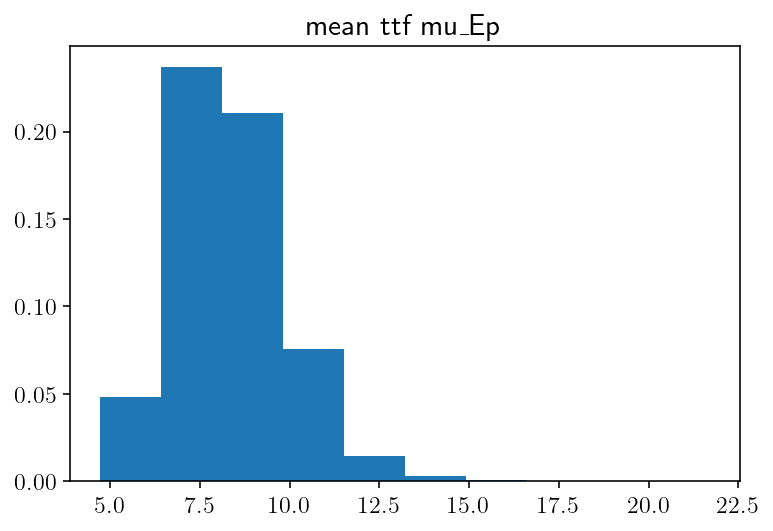

mcmc mean ttf mu_Ep 8.339228480296297


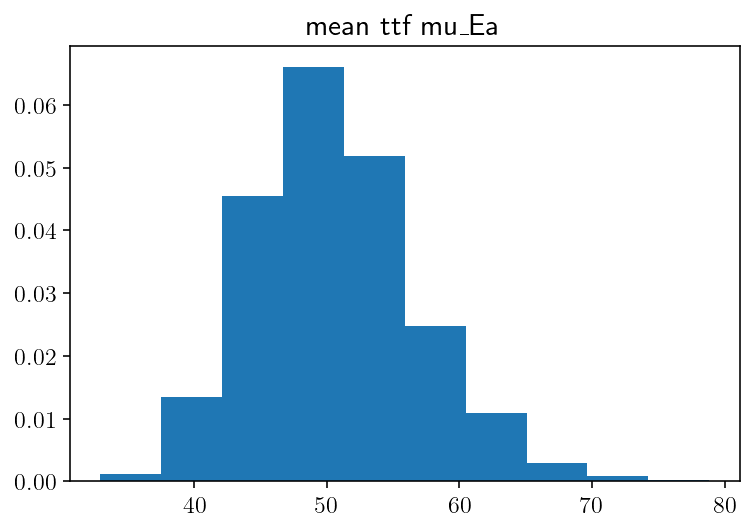

mcmc mean ttf mu_Ea 50.56849279176397


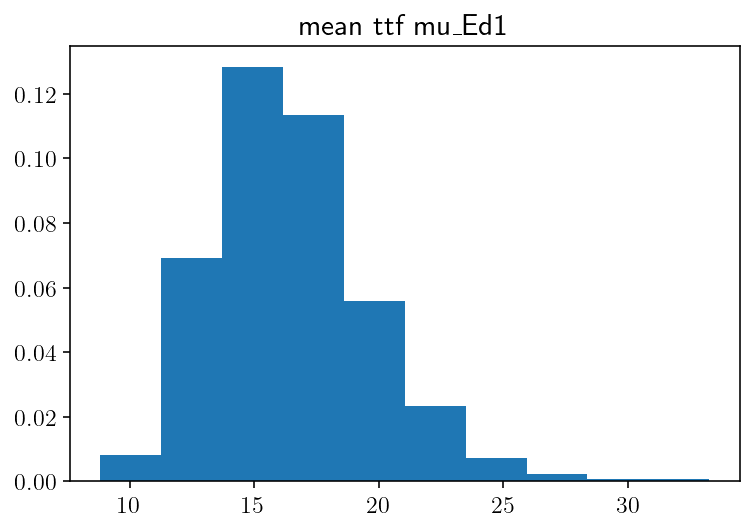

mcmc mean ttf mu_Ed1 16.472315063229143


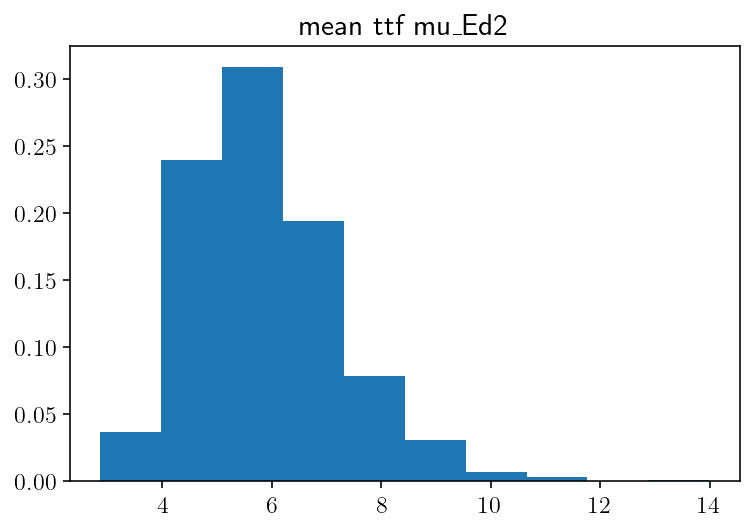

mcmc mean ttf mu_Ed2 5.861062269162804


In [15]:
samples = mcmc.get_samples()
for name in ['mu_Ep', 'mu_Ea', 'mu_Ed1', 'mu_Ed2']:
    vs = samples[name].to_py()
    plt.title(f'mean ttf {name}')
    plt.hist(vs, density=True)
    plt.show()
    print(f'mcmc mean ttf {name}', vs.mean())

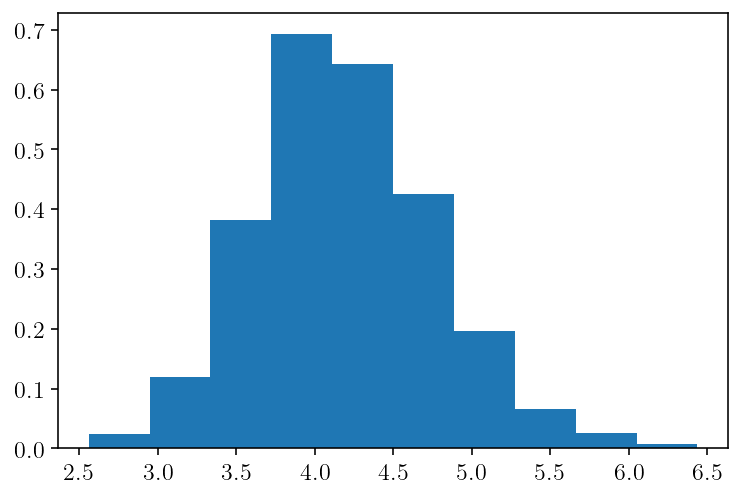

4.189813160596714


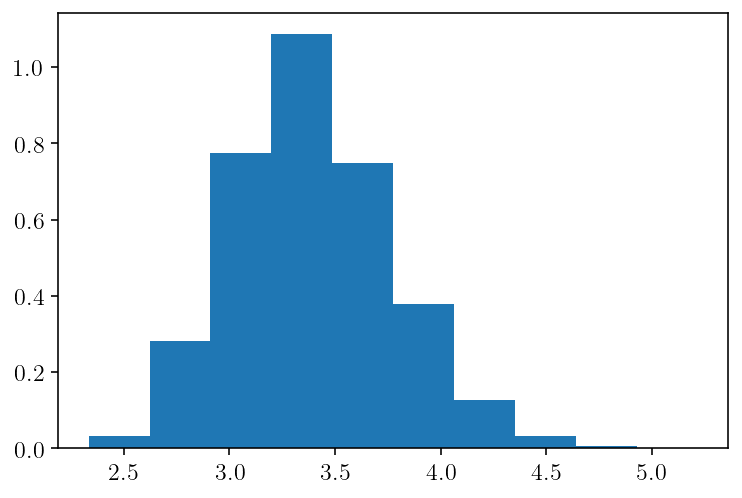

3.395150617425372


In [16]:
samples = mcmc.get_samples()
mu_S = 1.0 / (1.0 / samples['mu_Sp'] + 1.0 / samples['mu_Sa'] + 1.0 / samples['mu_Sd1'])
med_S = mu_S * np.log(2)
plt.hist(med_S, density=True)
plt.show()
print(med_S.mean())
mu_E = 1.0 / (1.0 / samples['mu_Ep'] + 1.0 / samples['mu_Ea'] + 1.0 / samples['mu_Ed1'])
med_E = mu_E * np.log(2)
plt.hist(med_E, density=True)
plt.show()
print(med_E.mean())
# for name in ['mu_Sp', 'mu_Sa', 'mu_Sd1', 'mu_Sd2']:
#     vs = samples[name].to_py()
#     plt.title(f'mean ttf {name}')
#     plt.hist(vs, density=True)
#     plt.show()
#     print(f'mcmc mean ttf {name}', vs.mean())

In [48]:
%%time
# true_mus = np.array([7, 14, 5.75, 48]) / np.log(2)
true_mus = np.array([12.25, 32, 12, 48]) / np.log(2)
p_L = 0.006
N_sim = 100
n_patients_early = np.empty(N_sim, dtype=np.int32)
for i in range(N_sim):
    seed = 10 + i
    rawdata_i = simulate_dataset(seed, *true_mus)
    for t in range(1, n_patients):
        raw_ti = rawdata_i[:t]
        suff_ti = sufficient_stats(raw_ti, raw_ti[-1, 0])
        mcmc.run(rng_key, suff_ti)
        samples = mcmc.get_samples()
        mu_S = 1.0 / (1.0 / samples['mu_Sd1'] + 1.0 / samples['mu_Sa'] + 1.0 / samples['mu_Sp'])
        mu_E = 1.0 / (1.0 / samples['mu_Ed1'] + 1.0 / samples['mu_Ea'] + 1.0 / samples['mu_Ep'])
        pr_success = jnp.sum(mu_S + 3 < mu_E) / mu_S.shape[0]
        stop = pr_success < p_L
        # print(f'pct chance of success={pr_success * 100:5.2f}% stop={stop}')
        n_patients_early[i] = t
        if stop:
            print(f'stopping after {n_patients_early[i]} patients')
            break

stopping after 41 patients
stopping after 53 patients
stopping after 27 patients
stopping after 16 patients
stopping after 27 patients
stopping after 40 patients
stopping after 15 patients
stopping after 16 patients
stopping after 62 patients
stopping after 19 patients
stopping after 42 patients
stopping after 48 patients
stopping after 41 patients
stopping after 20 patients
stopping after 41 patients
stopping after 78 patients
stopping after 21 patients
stopping after 30 patients
stopping after 16 patients
CPU times: user 19min 14s, sys: 4.41 s, total: 19min 19s
Wall time: 19min 21s


In [49]:
PET = (N_sim - np.sum(n_patients_early >= 83)) / N_sim
PET

0.19

In [51]:
np.quantile(n_patients_early, [0.25, 0.5, 0.75])

array([83., 83., 83.])

## Section 4: A randomized trial

In [1]:
import sys
sys.path.append('../kevlar/research/berry/')
import berrylib.util as util
util.setup_nb()

In [2]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import numpyro
import numpyro.distributions as dist
import numpyro.infer

import jax
import jax.numpy as jnp

from jax.config import config
# This line is critical for enabling 64-bit floats.
config.update("jax_enable_x64", True)

/Users/tbent/.mambaforge/envs/kevlar/lib/python3.9/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "
/Users/tbent/.mambaforge/envs/kevlar/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
n_patients = 14 * 6
max_n_months = 14
evaluation_period = 2


In [4]:
def simulate_dataset(seed, mu_ed1, mu_ed2, mu_ep, mu_ea):
    np.random.seed(seed)
    arm = scipy.stats.bernoulli.rvs(0.5, size=n_patients)
    ttfP = scipy.stats.expon.rvs(scale=mu_ep[arm], size=n_patients)
    ttfD1 = scipy.stats.expon.rvs(scale=mu_ed1[arm], size=n_patients)
    ttfD2 = scipy.stats.expon.rvs(scale=mu_ed2[arm], size=n_patients)
    ttfA = scipy.stats.expon.rvs(scale=mu_ea[arm], size=n_patients)
    start_date = np.linspace(0, 14, n_patients)
    P_date = start_date + ttfP
    D1_date = start_date + ttfD1
    D2_date = P_date + ttfD2
    D_date = np.where(D1_date > P_date, D2_date, D1_date)
    A_date = start_date + ttfA
    return np.stack((arm, start_date, D_date, P_date, A_date), axis=-1)

In [5]:
mu0_true = np.array([14, 5.75, 7, 48])
mu1_true = np.array([32, 12, 12.25, 48])
params = np.stack((mu0_true, mu1_true), axis=-1)
rawdata = simulate_dataset(10, *params)
rawdata[:5]

array([[  1.        ,   0.        ,  23.86550328,   4.38452547,
         41.67791093],
       [  0.        ,   0.1686747 ,   6.02795491,   0.34877017,
          9.9626824 ],
       [  1.        ,   0.3373494 ,  25.41928469,   4.76032986,
         46.21656521],
       [  1.        ,   0.5060241 ,   7.98177662,   3.90138107,
        105.14458851],
       [  0.        ,   0.6746988 ,   8.23062074,   6.38313949,
         35.58521604]])

In [6]:
def sufficient_stats(data, n_months):
    arm, start_date, D_date, P_date, A_date = data.T

    Y_d = D_date <= n_months

    # Only include evaluations that are within the time frame of the trial.
    evaluation_dates = (
        start_date[:, None]
        + (evaluation_period * np.arange(max_n_months // 2 + 1))[None, :]
    )
    include_eval = evaluation_dates <= n_months
    # For each patient and each time period, did we observe a progression?
    progress = (
        (evaluation_dates[:, :-1] < P_date[:, None])
        & (P_date[:, None] < evaluation_dates[:, 1:])
        & (evaluation_dates[:, 1:] < D_date[:, None])
        & include_eval[:, 1:]
    )
    Y_p = np.any(progress, axis=1)

    tau_k0 = np.empty(data.shape[0])
    tau_k0[Y_p] = evaluation_dates[:, 1:][progress]

    # This is some ugly code that figures out when the last observation of a patient was.
    last_observation_idx = (
        np.argmin(
            (evaluation_dates <= n_months) & (evaluation_dates < D_date[:, None]),
            axis=1,
        )
        - 1
    )
    tau_k0[~Y_p] = (
        evaluation_dates[np.arange(evaluation_dates.shape[0]), last_observation_idx]
    )[~Y_p]
    tau_k0 -= start_date

    T0 = np.minimum(D_date, n_months) - start_date

    Y_a = A_date < n_months
    T_a = np.minimum(A_date, n_months) - start_date
    data = np.stack((arm, Y_p, tau_k0, Y_d, T0, Y_a, T_a), axis=-1)
    return data

In [7]:
data = sufficient_stats(rawdata, max_n_months)

In [8]:
def log_likelihood_arm(data, ttf_d1, ttf_d2, ttf_p, ttf_a, arm_idx):
    (arm, Y_p, tau_k0, Y_d, T0, Y_a, T_a) = data.T
    ld1 = 1.0 / ttf_d1
    ld2 = 1.0 / ttf_d2
    lp = 1.0 / ttf_p
    la = 1.0 / ttf_a
    gamma = lp + ld1 - ld2
    prefix = (1.0 / gamma) * lp * ld2 ** Y_d * jnp.exp(-T0 * ld2)
    pi_k0_P = prefix * (
        jnp.exp(-(tau_k0 - evaluation_period) * gamma) - jnp.exp(-tau_k0 * gamma)
    )
    pi_k0_NP = prefix * (
        jnp.exp(-tau_k0 * gamma) - jnp.exp(-T0 * gamma)
    ) + ld1 ** Y_d * jnp.exp(-T0 * (lp + ld1))
    
    include = arm == arm_idx
    a_term = jnp.log(la) * (Y_a * include).sum() + -(T_a * include).sum() * la
    return jnp.sum(include * (Y_p * jnp.log(pi_k0_P) + (1 - Y_p) * jnp.log(pi_k0_NP))) + a_term

def log_likelihood(data, pc, pt):
    return log_likelihood_arm(data, *pc, 0) + log_likelihood_arm(data, *pt, 1)

log_likelihood(data, params[:,0], params[:,1])

DeviceArray(-249.37344502, dtype=float64)

In [9]:
class Randomized(dist.Distribution):
    def __init__(self, pc, pt, validate_args=None):
        self.pc = pc
        self.pt = pt
        super(Randomized, self).__init__(
            batch_shape=jnp.shape(pc[0]), validate_args=validate_args
        )

    def sample(self, key):
        raise NotImplementedError()

    def log_prob(self, data):
        return log_likelihood(data, self.pc, self.pt)

In [10]:
Randomized(params[:,0], params[:,1]).log_prob(data)

DeviceArray(-249.37344502, dtype=float64)

In [11]:
a_Ep, b_Ep = 2.039, 13.574
a_Ea, b_Ea = 55.237, 2646.580
a_Ed1, b_Ed1 = 18.852, 262.529
a_Ed2, b_Ed2 = 5.974, 32.053

def sample(data):
    mu_Cp = numpyro.sample("mu_Cp", dist.InverseGamma(a_Ep, b_Ep))
    mu_Ca = numpyro.sample("mu_Ca", dist.InverseGamma(a_Ea, b_Ea))
    mu_Cd1 = numpyro.sample("mu_Cd1", dist.InverseGamma(a_Ed1, b_Ed1))
    mu_Cd2 = numpyro.sample("mu_Cd2", dist.InverseGamma(a_Ed2, b_Ed2))
    mu_Ep = numpyro.sample("mu_Ep", dist.InverseGamma(a_Ep, b_Ep))
    mu_Ea = numpyro.sample("mu_Ea", dist.InverseGamma(a_Ea, b_Ea))
    mu_Ed1 = numpyro.sample("mu_Ed1", dist.InverseGamma(a_Ed1, b_Ed1))
    mu_Ed2 = numpyro.sample("mu_Ed2", dist.InverseGamma(a_Ed2, b_Ed2))
    numpyro.sample(
        "data",
        Randomized(
            jnp.array([mu_Cd1, mu_Cd2, mu_Cp, mu_Ca]),
            jnp.array([mu_Ed1, mu_Ed2, mu_Ep, mu_Ea]),
        ),
        obs=data,
    )


seed = 10
n_samples = 100000
nuts_kernel = numpyro.infer.NUTS(sample)
mcmc = numpyro.infer.MCMC(
    nuts_kernel,
    progress_bar=False,
    num_warmup=100,
    num_samples=n_samples,
    jit_model_args=True,
)
rng_key = jax.random.PRNGKey(seed)

In [12]:
%%time
mcmc.run(rng_key, data)

CPU times: user 10.4 s, sys: 104 ms, total: 10.5 s
Wall time: 10.5 s


In [14]:
samples = mcmc.get_samples()
mu_C = 1.0 / (1.0 / samples['mu_Cd1'] + 1.0 / samples['mu_Ca'] + 1.0 / samples['mu_Cp'])
mu_E = 1.0 / (1.0 / samples['mu_Ed1'] + 1.0 / samples['mu_Ea'] + 1.0 / samples['mu_Ep'])
pr_success = jnp.sum(mu_C + 3 < mu_E) / mu_C.shape[0]
pr_better = jnp.sum(mu_C < mu_E) / mu_C.shape[0]
pr_success, pr_better

(DeviceArray(0.02088, dtype=float64), DeviceArray(0.75996, dtype=float64))

In [15]:
def inv_gamma_log_prior(x, a, b):
    return -b / x + a * jnp.log(b) - (a + 1) * jnp.log(x) - jax.scipy.special.gammaln(a)


def log_prior(pc, pt):
    return (
        inv_gamma_log_prior(pc[0], a_Ed1, b_Ed1)
        + inv_gamma_log_prior(pc[1], a_Ed2, b_Ed2)
        + inv_gamma_log_prior(pc[2], a_Ep, b_Ep)
        + inv_gamma_log_prior(pc[3], a_Ea, b_Ea)
        + inv_gamma_log_prior(pt[0], a_Ed1, b_Ed1)
        + inv_gamma_log_prior(pt[1], a_Ed2, b_Ed2)
        + inv_gamma_log_prior(pt[2], a_Ep, b_Ep)
        + inv_gamma_log_prior(pt[3], a_Ea, b_Ea)
    )

In [16]:
p = params.T.flatten()
obj = jax.jit(lambda params: log_likelihood(data, params[:4], params[4:]) + log_prior(params[:4], params[4:]))
gradLL = jax.jit(jax.grad(obj))
hessLL = jax.jit(jax.hessian(obj))
obj(p), log_likelihood(data, params[:,0], params[:,1])

(DeviceArray(-276.80242437, dtype=float64),
 DeviceArray(-249.37344502, dtype=float64))

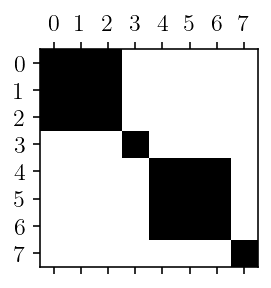

In [17]:

plt.figure(figsize=(2,2))
plt.spy(hessLL(p).to_py())
plt.show()

In [18]:
def gaussian_posteriors(data):
    obj = jax.jit(lambda params: log_likelihood(data, params[:4], params[4:]) + log_prior(params[:4], params[4:]))
    gradLL = jax.jit(jax.grad(obj))
    hessLL = jax.jit(jax.hessian(obj))

    result = scipy.optimize.minimize(
        lambda p: -obj(p).to_py(),
        np.ones(8),
        jac=lambda p: -gradLL(p).to_py(),
        hess=lambda p: -hessLL(p).to_py(),
        method="newton-cg",
    )
    mu_gaussian = result['x']
    sigma_gaussian = np.sqrt(np.diagonal(np.linalg.inv(-hessLL(mu_gaussian))))
    return mu_gaussian, sigma_gaussian
mu_gaussian, sigma_gaussian = gaussian_posteriors(data)

In [19]:
def inla_posteriors(data, mu_gaussian, sigma_gaussian, N=51):
    def obj(params, i, xi):
        params = params.at[i].set(xi)
        return log_likelihood(data, params[:4], params[4:]) + log_prior(params[:4], params[4:])
    obj = jax.jit(obj)
    gradLL = jax.jit(jax.grad(obj))
    hessLL = jax.jit(jax.hessian(obj))

    w = 8
    N = 101
    pi_pts = np.empty((8, N))
    pi_wts = np.empty((8, N))
    logpost = np.empty((8, N))
    for i in range(8):
        left = max(mu_gaussian[i] - sigma_gaussian[i] * w, 0.05)
        right = mu_gaussian[i] + sigma_gaussian[i] * w
        pi_rule = util.simpson_rule(N, left, right)
        pi_pts[i] = pi_rule.pts
        pi_wts[i] = pi_rule.wts
        for j in range(N):
            xi = pi_rule.pts[j]
            result = scipy.optimize.minimize(
                lambda p: -obj(p, i, xi).to_py(),
                np.ones(8),
                jac=lambda p: -gradLL(p, i, xi).to_py(),
                hess=lambda p: -hessLL(p, i, xi).to_py(),
                method="newton-cg",
            )
            optimum = result['x']
            optimum[i] = xi
            hess = hessLL(optimum, i, xi)
            hess = np.delete(np.delete(hess.to_py(), i, 0), i, 1)
            logdethess = np.linalg.slogdet(hess)[1]
            logpost[i, j] = obj(optimum, i, xi) - 0.5 * logdethess
    post = np.exp(logpost)
    post /= np.sum(post * pi_wts, axis=1)[:, None]
    return post, logpost, pi_pts, pi_wts
inla_post, _, inla_pi_pts, _ = inla_posteriors(data, mu_gaussian, sigma_gaussian)

In [20]:
def comparison_plots(inla_post, inla_pi_pts, samples, mu_gaussian, sigma_gaussian):
    for j, arm in enumerate(["C", "E"]):
        arm_name = dict(C="Control", E="Treatment")[arm]
        plt.figure(figsize=(9, 9), constrained_layout=True)
        for i, p_name in enumerate(["d1", "d2", "p", "a"]):
            full_name = dict(
                d1="Initial death",
                d2="Post-progression death",
                p="Progression",
                a="Adverse event",
            )[p_name]
            name = f"mu_{arm}{p_name}"
            plt.subplot(2, 2, 1 + i)
            plt.title(f"{arm_name}: {full_name}")
            vs = samples[name].to_py()
            plt_vs = np.linspace(0, np.quantile(vs, 0.999), 1000)
            gaussian_pdf = scipy.stats.norm.pdf(
                plt_vs, mu_gaussian[j * 4 + i], sigma_gaussian[j * 4 + i]
            )
            # plt.hist(vs, density=True)
            plt.plot(plt_vs, scipy.stats.gaussian_kde(vs)(plt_vs), "k-", label="MCMC")
            plt.plot(plt_vs, gaussian_pdf, "r-", label="Gaussian")
            plt.plot(inla_pi_pts[j * 4 + i], inla_post[j * 4 + i], "b-", label="INLA")
            plt.xlim(np.quantile(vs, [0.001, 0.999]))
            plt.xlabel('Months')
            plt.ylabel('$p(\mu|\mathrm{data})$')
            plt.legend()
            # print(f"mcmc mean ttf {name}", vs.mean())
        plt.show()

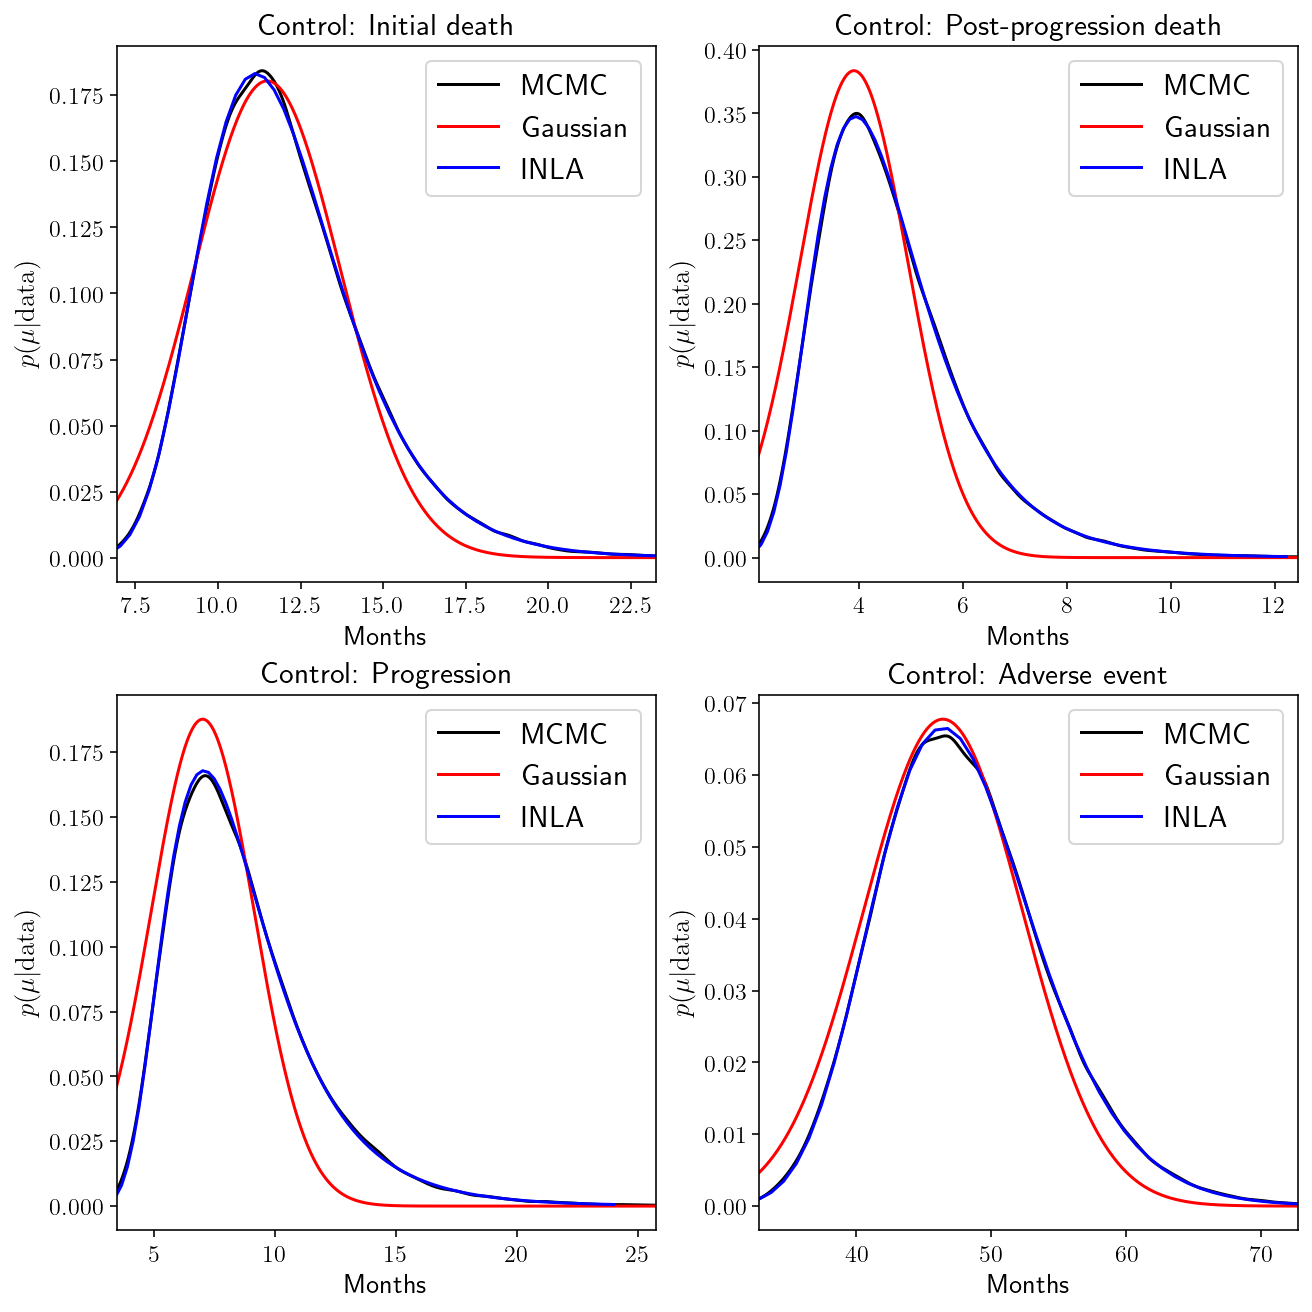

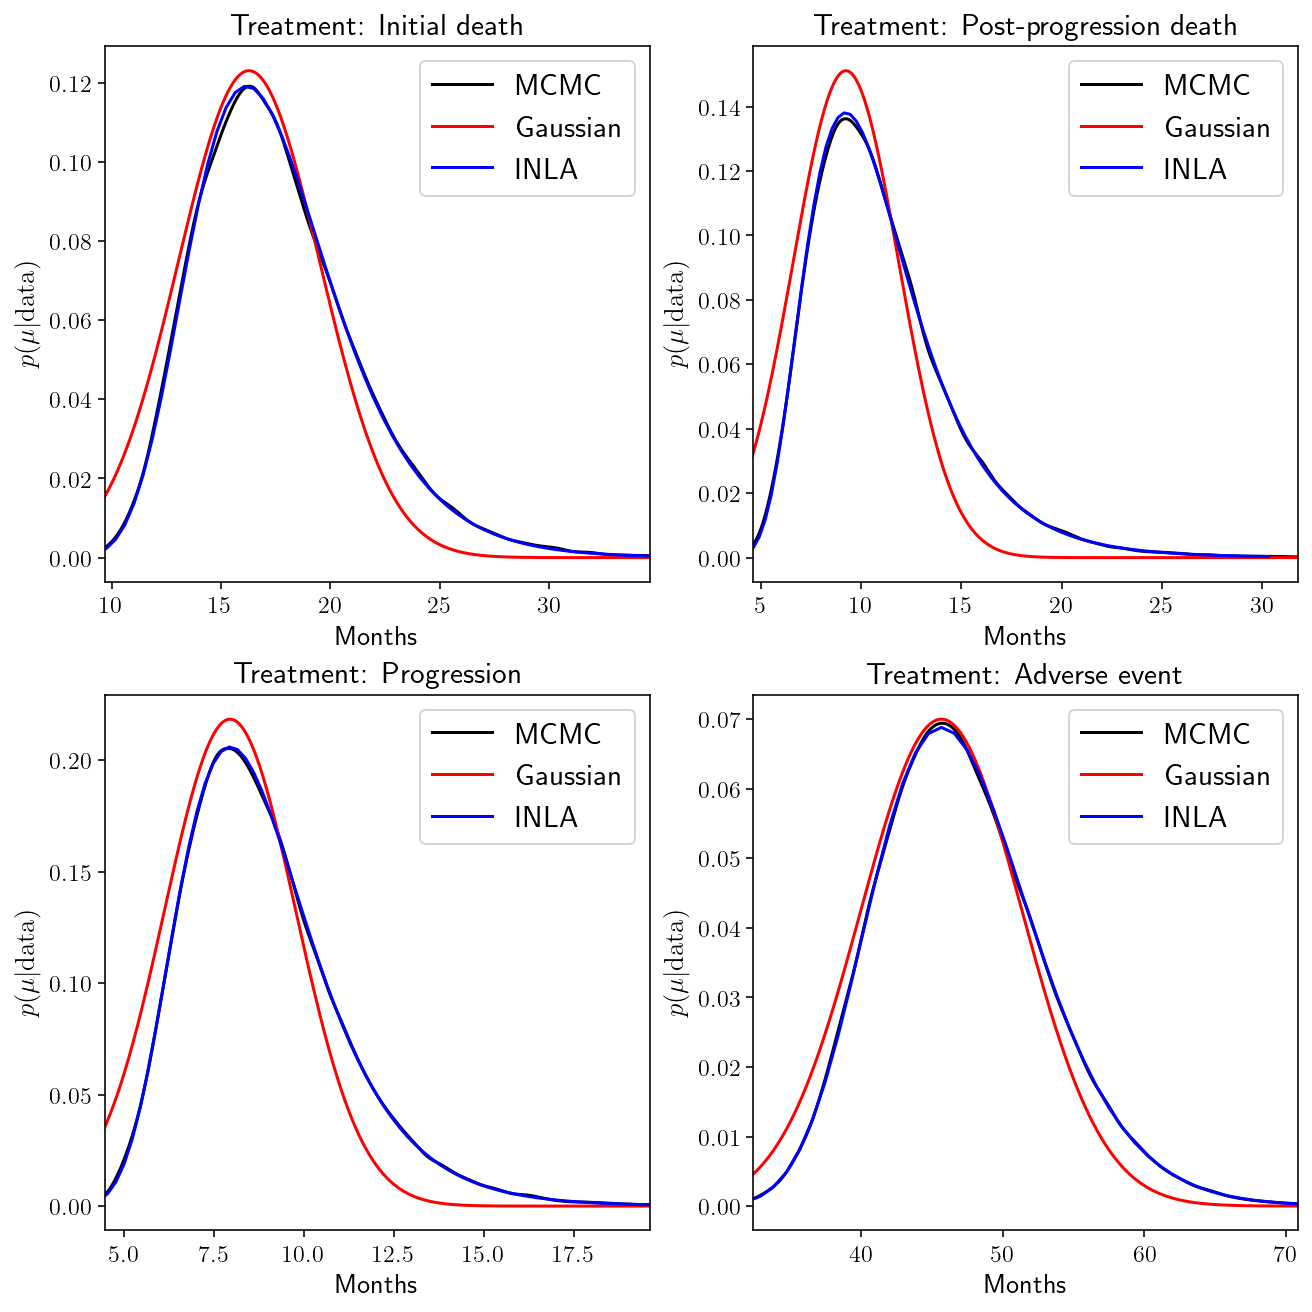

In [21]:

comparison_plots(inla_post, inla_pi_pts, samples, mu_gaussian, sigma_gaussian)

- what is the hessian of the loglikelihood at the map? hessian vs third derivative (or higher order?)?
- explore low observation time for post-progression.

array([0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [49]:
# mu0_true = np.array([7, 14, 5.75, 48])
# mu1_true = np.array([12.25, 32, 12, 48])
mu0_true = np.array([14, 5.75, 800, 48])
mu1_true = np.array([32, 12, 800, 48])
params = np.stack((mu0_true, mu1_true), axis=-1)
rawdata = simulate_dataset(10, *params)
data = sufficient_stats(rawdata, max_n_months)
print(data[:,1].sum())

0.0


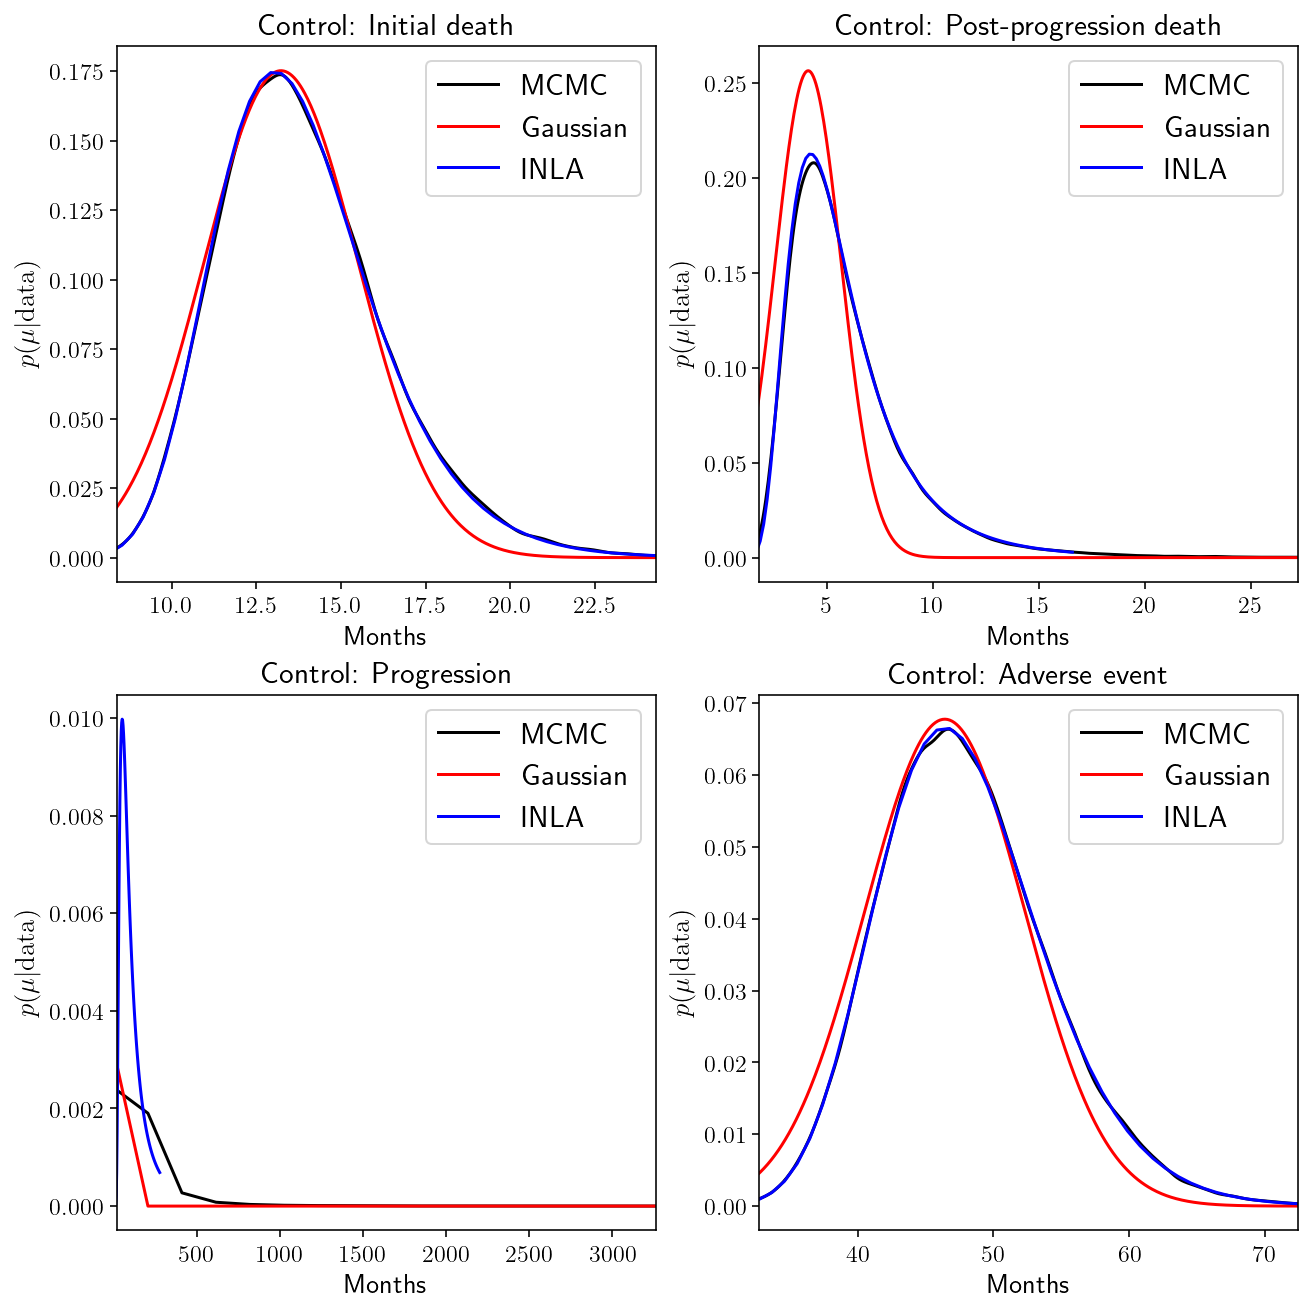

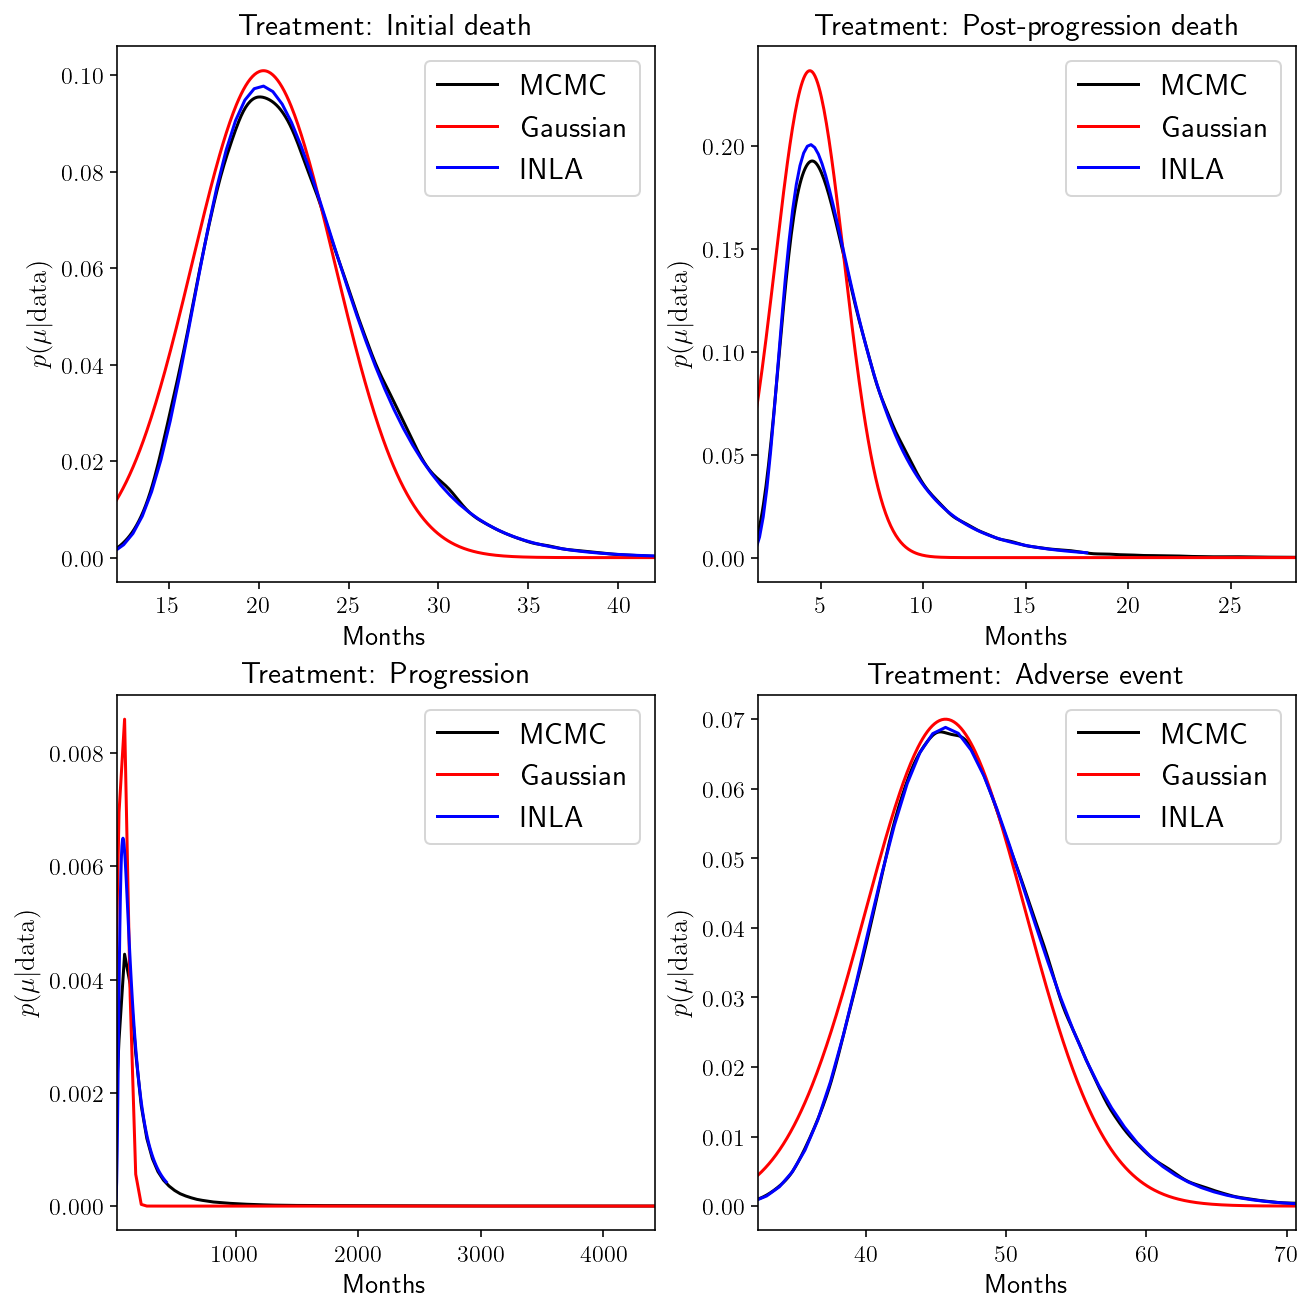

In [50]:

mcmc.run(rng_key, data)
samples = mcmc.get_samples()
mu_gaussian, sigma_gaussian = gaussian_posteriors(data)
inla_post, _, inla_pi_pts, _ = inla_posteriors(data, mu_gaussian, sigma_gaussian)

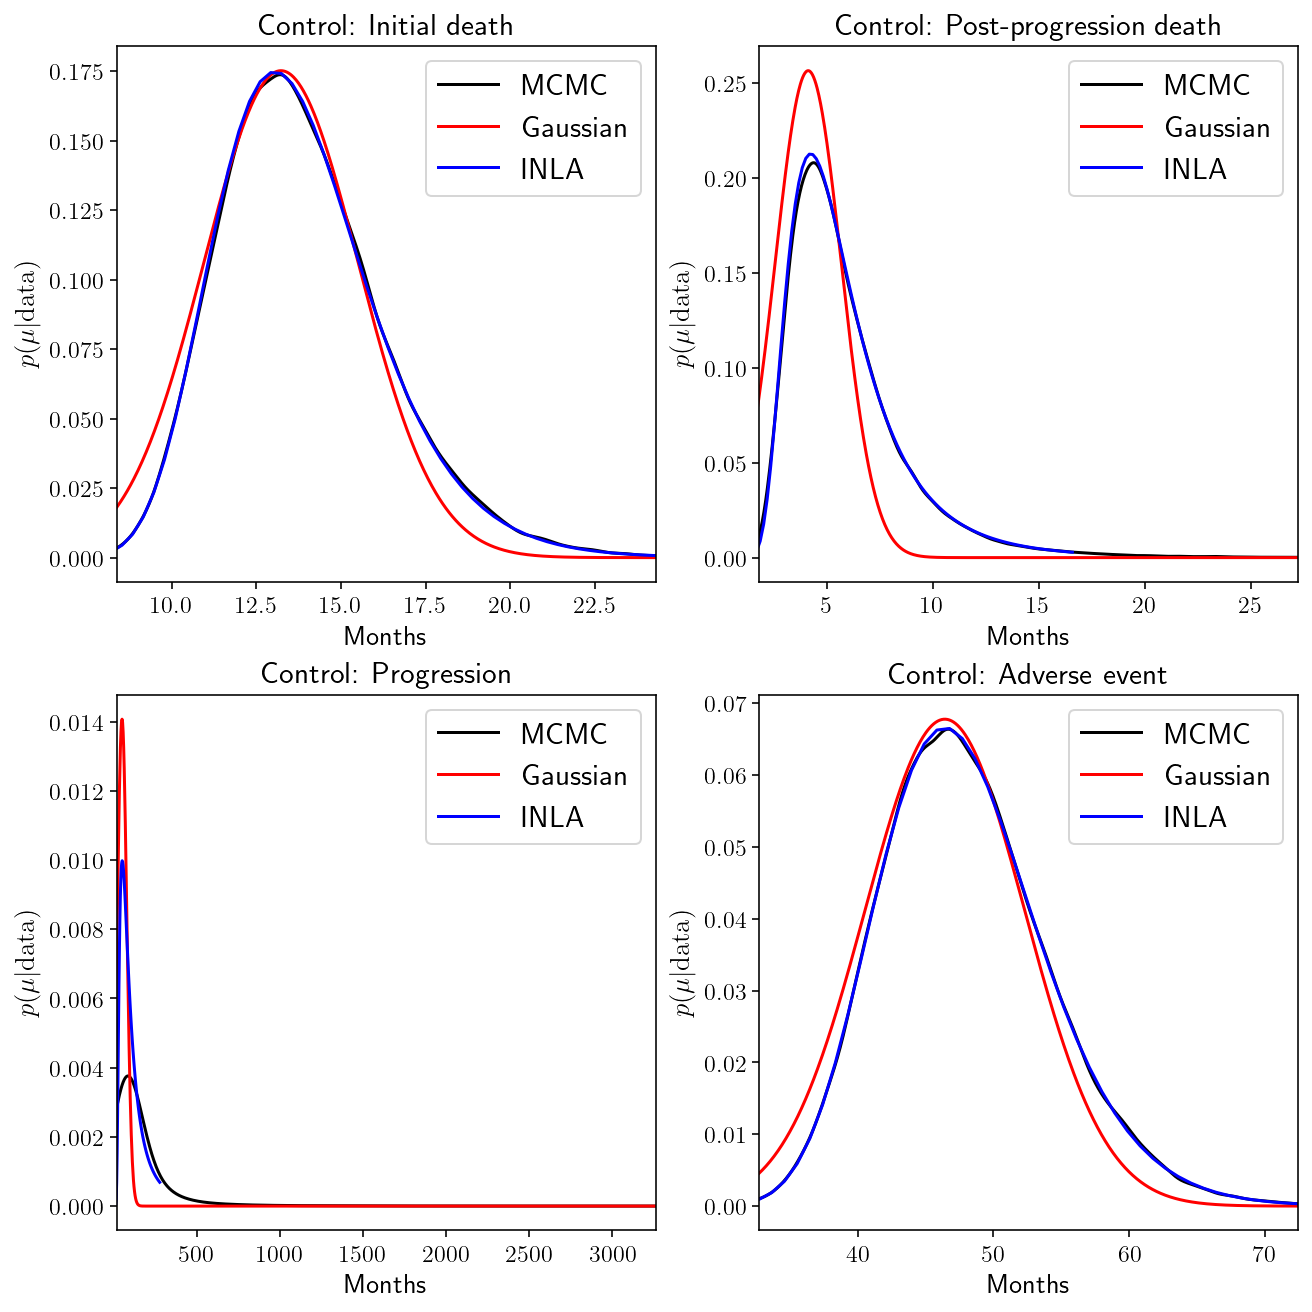

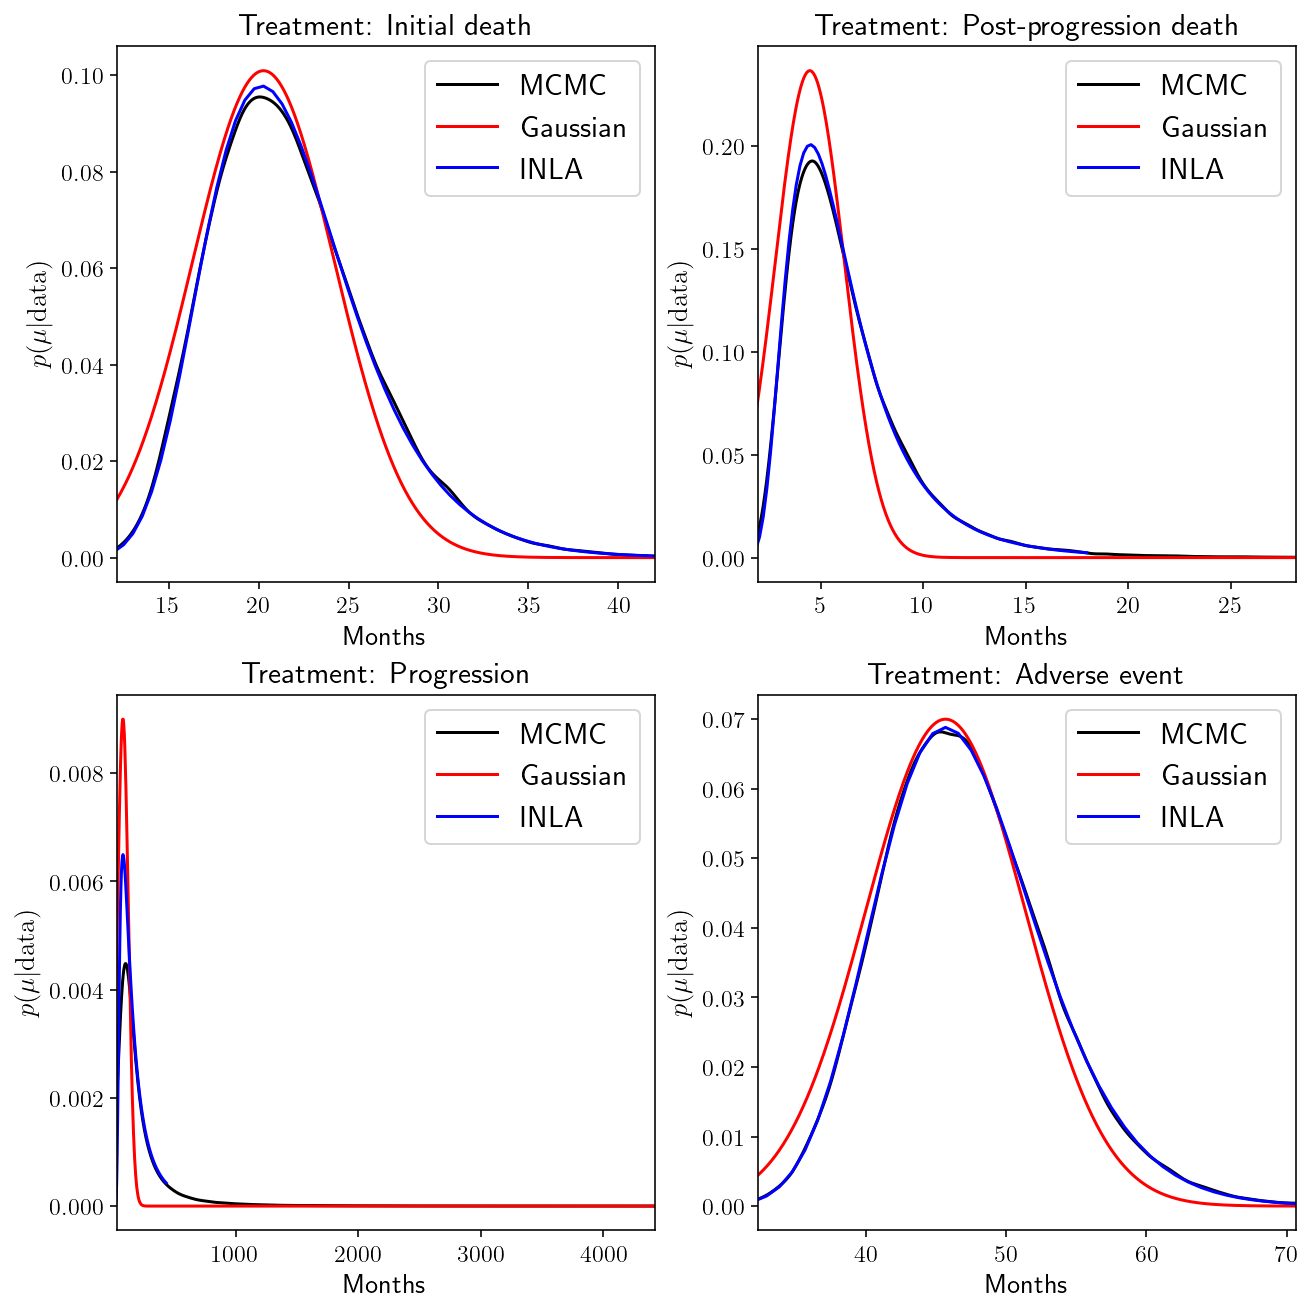

In [52]:

comparison_plots(inla_post, inla_pi_pts, samples, mu_gaussian, sigma_gaussian)